# MNIST Project

## Imports

In [1]:
import torch
from torch import Tensor 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import src.dlc_practical_prologue as prologue

## Loading the Data

In [2]:
def onehot_Y(target):
    '''
    Create one-hot labels for Y
    '''
    res = torch.zeros(target.size(0), 2)
    res[range(target.size(0)), target] = 1
    return res

In [3]:
def onehot_Class(target):
    res = torch.zeros(target.size(0), 10*target.size(1))
    res[range(target.size(0)), target[:, 0]] = 1
    res[range(target.size(0)), target[:, 1] + 10] = 1
    return res

In [4]:
N = 1000
train_X, train_Y, train_Class, test_X, test_Y, test_Class = prologue.generate_pair_sets(N)

In [5]:
#train_Y = onehot_Y(train_Y).long()
#train_Class = onehot_Class(train_Class).long()
#test_Y = onehot_Y(test_Y).long()
#test_Class = onehot_Class(test_Class).long()

In [6]:
mu, std = train_X.mean(), train_X.std()
train_X.sub_(mu).div_(std)
test_X.sub_(mu).div_(std)

tensor([[[[-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          ...,
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653]],

         [[-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          ...,
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653]]],


        [[[-0.4653, -0.4653, -0.4653,  ..., -0.4653, -0.4653, -0.4653],
          [-0.4653, -0.4653,

## Model 1: Naive convnet
For the first model, we create a naive convnet, not taking into account the structrue of the channels.

In [58]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [59]:
def train_model(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, verbose=False):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if(verbose): print(loss)
    return model

In [60]:
def train_model_path(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, test_X, test_Y, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
    return model, train_error, test_error

In [61]:
def compute_nb_errors(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        _, pred = torch.max(out.data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

In [62]:
model1 = convNet()
model1, train_path, test_path = train_model_path(model1, nn.CrossEntropyLoss(), optim.SGD(model1.parameters(), lr=1e-1), \
                                                 100, 100, train_X, train_Y, test_X, test_Y, verbose=True)

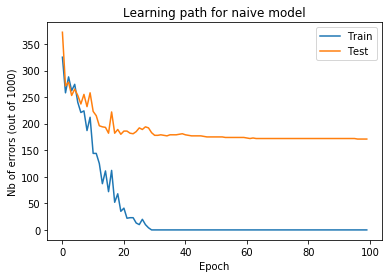

171

In [63]:
import matplotlib.pyplot as plt
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
compute_nb_errors(model1, test_X, test_Y, 100)

We observe that this model does not manage to learn the mapping very well.

## Model 2: Using transfer learning

### Part 1: Study of a good functioning digit detection network for 28x28 images

In [12]:
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = False, normalize = True, flatten = False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [13]:
train_input, train_target = Variable(train_input), Variable(train_target)
model = Net()

In [14]:
model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=1e-1), 50, 100, train_input, train_target)

In [15]:
compute_nb_errors(model, test_input, test_target, 100)

66

### Part 2: Adapting the network to 14x14 images

In [16]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].resize_(1000,1,14,14), train_X[:,1,:,:].resize_(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].resize_(1000,1,14,14), test_X[:,1,:,:].resize_(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [17]:
class Net_14px(nn.Module):
    def __init__(self):
        super(Net_14px, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [18]:
model_14px = Net_14px()
model_14px = train_model(model_14px, nn.CrossEntropyLoss(), optim.Adam(model_14px.parameters()), 50, 100, \
                         train_input_14px, train_target_14px, verbose=True)

tensor(2.3069, grad_fn=<NllLossBackward>)
tensor(2.3006, grad_fn=<NllLossBackward>)
tensor(2.2915, grad_fn=<NllLossBackward>)
tensor(2.2800, grad_fn=<NllLossBackward>)
tensor(2.2678, grad_fn=<NllLossBackward>)
tensor(2.2481, grad_fn=<NllLossBackward>)
tensor(2.2286, grad_fn=<NllLossBackward>)
tensor(2.2114, grad_fn=<NllLossBackward>)
tensor(2.1890, grad_fn=<NllLossBackward>)
tensor(2.1473, grad_fn=<NllLossBackward>)
tensor(2.1174, grad_fn=<NllLossBackward>)
tensor(2.0849, grad_fn=<NllLossBackward>)
tensor(2.0435, grad_fn=<NllLossBackward>)
tensor(2.0074, grad_fn=<NllLossBackward>)
tensor(1.9643, grad_fn=<NllLossBackward>)
tensor(1.9169, grad_fn=<NllLossBackward>)
tensor(1.8726, grad_fn=<NllLossBackward>)
tensor(1.8244, grad_fn=<NllLossBackward>)
tensor(1.7941, grad_fn=<NllLossBackward>)
tensor(1.7428, grad_fn=<NllLossBackward>)
tensor(1.6930, grad_fn=<NllLossBackward>)
tensor(1.6546, grad_fn=<NllLossBackward>)
tensor(1.6292, grad_fn=<NllLossBackward>)
tensor(1.5934, grad_fn=<NllLossBac

In [19]:
compute_nb_errors(model_14px, test_input_14px, test_target_14px, 100)

1805

# Model 3: Naive model with parameter sharing

In [31]:
class convNet_v2(nn.Module):
    def __init__(self):
        super(convNet_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 2)
        self.do = nn.Dropout(0.3)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].resize(x.size(0),1,14,14)), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].resize(x.size(0),1,14,14)), kernel_size=2, stride=2))
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2))
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2))
        x = F.relu(self.fc1(self.do(torch.cat((x1.view(-1, 256), x2.view(-1, 256))))))
        x = self.fc2(x)
        return x

In [44]:
test_input_14px.size()

torch.Size([2000, 1, 14, 14])

In [32]:
model3 = convNet_v2()
model3 = train_model(model3, nn.CrossEntropyLoss(), optim.SGD(model3.parameters(), lr=1e-2), 100, 100, train_X, train_Y, verbose=True)

C:\Users\yvesr\Miniconda3\envs\deep_learning\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.6918, grad_fn=<NllLossBackward>)
tensor(0.6990, grad_fn=<NllLossBackward>)
tensor(0.6874, grad_fn=<NllLossBackward>)
tensor(0.6991, grad_fn=<NllLossBackward>)
tensor(0.6866, grad_fn=<NllLossBackward>)
tensor(0.7008, grad_fn=<NllLossBackward>)
tensor(0.6917, grad_fn=<NllLossBackward>)
tensor(0.6916, grad_fn=<NllLossBackward>)
tensor(0.6886, grad_fn=<NllLossBackward>)
tensor(0.6901, grad_fn=<NllLossBackward>)
tensor(0.6905, grad_fn=<NllLossBackward>)
tensor(0.6918, grad_fn=<NllLossBackward>)
tensor(0.6898, grad_fn=<NllLossBackward>)
tensor(0.6856, grad_fn=<NllLossBackward>)
tensor(0.6861, grad_fn=<NllLossBackward>)
tensor(0.6920, grad_fn=<NllLossBackward>)
tensor(0.6803, grad_fn=<NllLossBackward>)
tensor(0.6908, grad_fn=<NllLossBackward>)
tensor(0.6849, grad_fn=<NllLossBackward>)
tensor(0.6878, grad_fn=<NllLossBackward>)
tensor(0.6905, grad_fn=<NllLossBackward>)
tensor(0.6832, grad_fn=<NllLossBackward>)
tensor(0.6848, grad_fn=<NllLossBackward>)
tensor(0.6775, grad_fn=<NllLossBac

In [33]:
model.train(False)
compute_nb_errors(model3, test_X, test_Y, 100)

475